# SARIMAX

- **S**easonal **ARIMA** with e**X**ogenous regressors
- one **SARIMAX** model per zone
- seasonal period: m=144 daily pattern
- exogenous features: Temperature, Humidity, Wind Speed, general diffuse flows, diffuse flows

### import libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(".."))

from common.load_data import load_data
from common.time_based_features import add_time_based_features
from common.chronological_split import chronological_train_test_split

[INFO] Using 'DateTime' as datetime index column
Train period: 2017-01-02 00:00:00 to 2017-10-19 09:20:00
Test period: 2017-10-19 09:30:00 to 2017-12-30 23:50:00


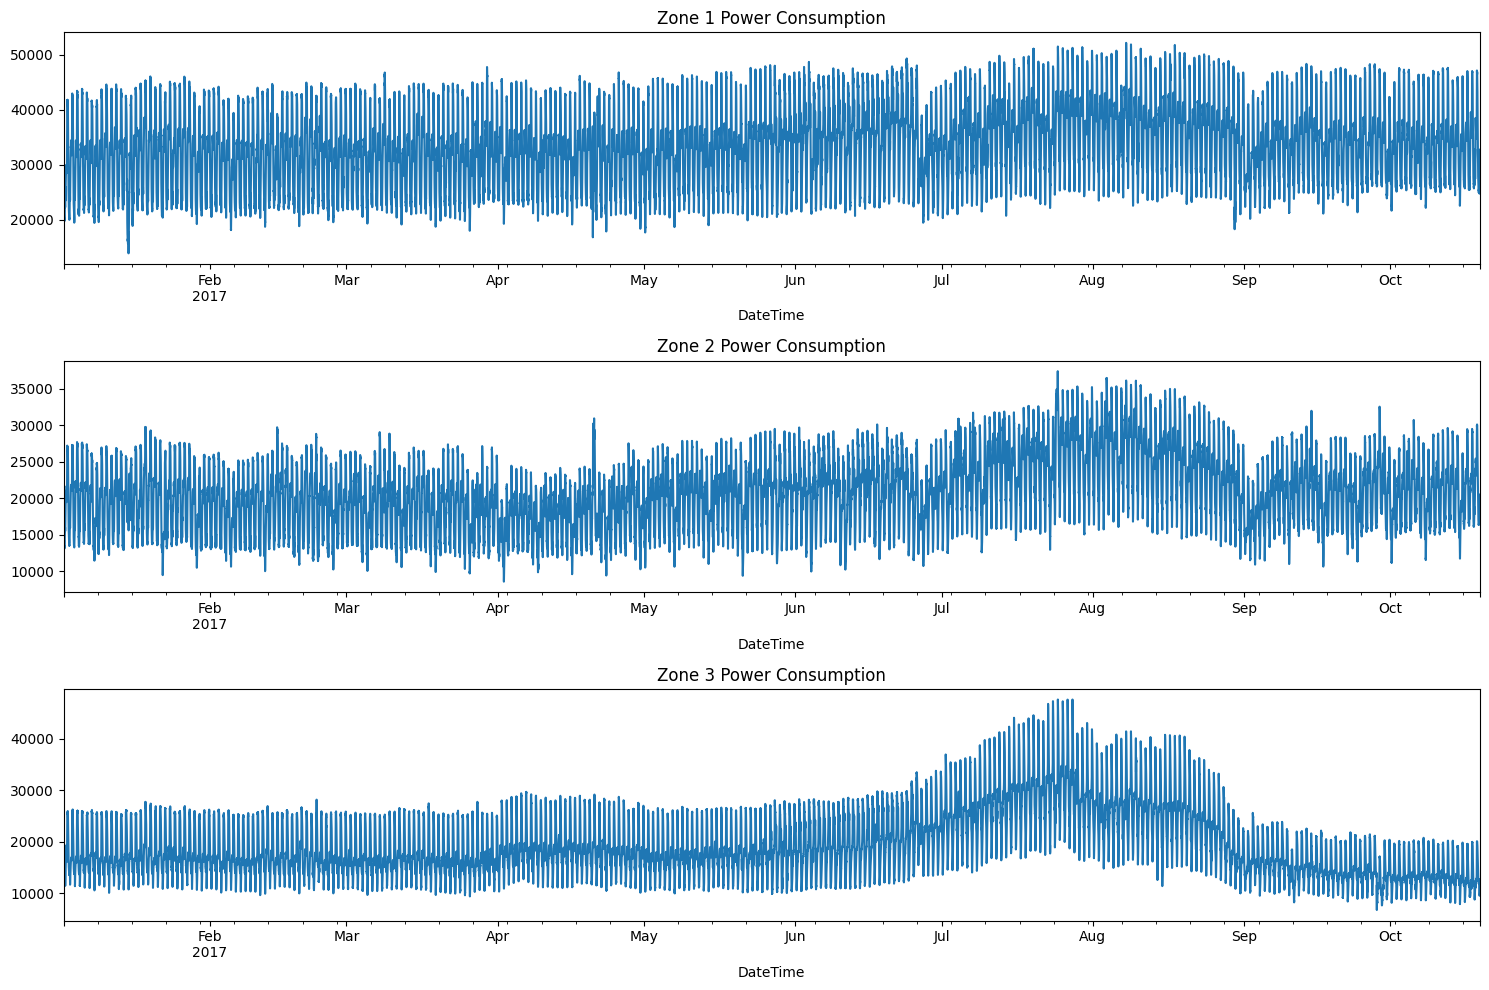

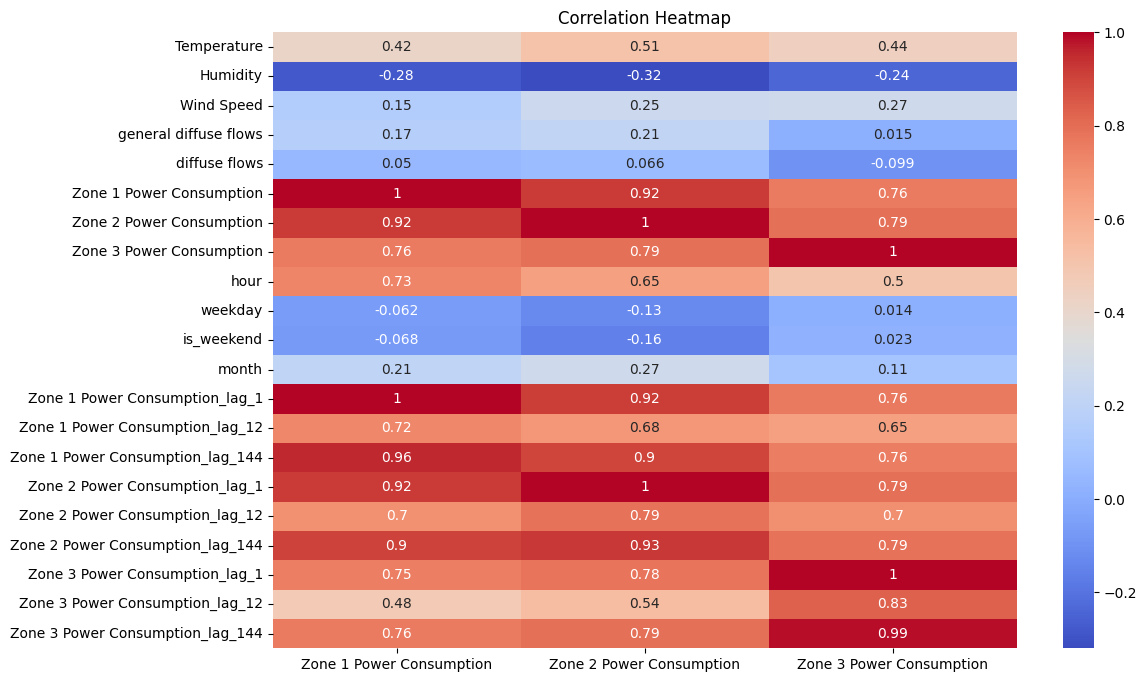

In [2]:
from concurrent.futures import ProcessPoolExecutor
from common.sarimax import sarimax_fast
from functools import partial
# -------------------------------
# 1. Load and preprocess
# -------------------------------
# Load and preprocess data
dataset = (
    load_data(file_path='..\Data\Tetuan City power consumption.csv')
    .pipe(add_time_based_features)
)
zones = [
    'Zone 1 Power Consumption',
    'Zone 2 Power Consumption',
    'Zone 3 Power Consumption'
]

lags = [1, 12, 144]
for zone in zones:
    for lag in lags:
        dataset[f'{zone}_lag_{lag}'] = dataset[zone].shift(lag)

dataset = dataset.dropna()

# Chronological split
dataset_train, dataset_test = chronological_train_test_split(dataset, train_ratio=0.8, val_ratio=None)

# Ensure proper chronological split
print(f"Train period: {dataset_train.index.min()} to {dataset_train.index.max()}")
print(f"Test period: {dataset_test.index.min()} to {dataset_test.index.max()}")

# Verify no overlap
assert dataset_train.index.max() < dataset_test.index.min(), "Data leakage detected - test period starts before train period ends"


zones = [
    'Zone 1 Power Consumption',
    'Zone 2 Power Consumption',
    'Zone 3 Power Consumption'
]

# Plot power consumption patterns
plt.figure(figsize=(15, 10))
i = 1
for zone in zones:
    plt.subplot(3, 1, i)
    i += 1
    dataset_train[zone].plot(title=zone)    

plt.tight_layout()
plt.show()

# Examine correlations
corr_matrix = dataset_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Zone 1 Power Consumption', 
                        'Zone 2 Power Consumption',
                        'Zone 3 Power Consumption']], 
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()




#### Key findings
- **Strong Temporal Patterns**:
  - Hour has very high correlation with power consumption (0.73 for Zone 1, 0.65 for Zone 2)
  - This confirms daily cycles are crucial for modeling
- **Weather Impact**:
  - Temperature shows moderate correlation (0.42-0.51 across zones)
  - Humidity shows negative correlation (-0.24 to -0.32)
  - Wind speed has weaker but notable correlation (0.15-0.27)
- **Zone Relationships**:
  - Zones are highly correlated with each other (0.76-0.92)
  - Suggests potential for multivariate modeling or using other zones as features
- **Unexpected Findings**:
  - Diffuse flows show minimal correlation with consumption
  - Weekday/weekend indicators show weak relationships

### Create Features

In [3]:
def create_features(df):
    """Feature engineering applied consistently to train and test sets"""
    df = df.copy()
    
    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    
    # Weather interactions
    df['temp_humidity'] = df['Temperature'] * df['Humidity']
    
    # Time-based flags
    df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)
    

    return df

In [4]:
# Apply to both sets
#dataset_train_fe = create_features(dataset_train)
#dataset_test_fe = create_features(dataset_test)

# Remove low-correlation features
low_corr_features = ['general diffuse flows', 'diffuse flows', 'weekday']
dataset_train_fe = create_features(dataset_train) #.drop(columns=low_corr_features)
dataset_test_fe = create_features(dataset_test) # .drop(columns=low_corr_features)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings  # Added missing import

def correct_sarimax(zone, train, test, exog_vars):
    """
    SARIMAX implementation with:
    - Correct time-varying regression setup
    - Maintained train/test separation
    - Returns fitted SARIMAXResults for further analysis
    """
    import warnings
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np
    import pandas as pd

    # Prepare data
    y_train = train[zone]
    X_train = train[exog_vars]
    y_test = test[zone]
    X_test = test[exog_vars]
    
    # Model configuration
    model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1, 1, 1),            # Non-seasonal components
        seasonal_order=(1, 1, 1, 24),  # Daily seasonality
        time_varying_regression=True,
        mle_regression=False
    )
    
    # Fit model with warnings suppressed
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            results = model.fit(
                method='nm',  # Nelder-Mead
                maxiter=100,
                disp=False,
                cov_type='none'
            )

            # In-sample prediction (train)
            train_pred = results.fittedvalues
            train_pred.index = y_train.index

            # Out-of-sample forecast (test)
            forecast = results.get_forecast(steps=len(y_test), exog=X_test)
            test_pred = forecast.predicted_mean

            # Calculate metrics for test
            metrics = {
                'zone': zone,
                'rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
                'mae': mean_absolute_error(y_test, test_pred),
                'r2': r2_score(y_test, test_pred),
                'train_predicted': train_pred,
                'test_predicted': test_pred,
                'actual_train': y_train,
                'actual_test': y_test
            }
            
            return metrics, results  # Return fitted SARIMAXResults
            
        except Exception as e:
            print(f"Model failed for {zone}: {str(e)}")
            return None, None



C:\Users\abatl\AppData\Local\Temp\ipykernel_17636\2789114475.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  train_resampled = dataset_train_fe.resample('30T').mean()
C:\Users\abatl\AppData\Local\Temp\ipykernel_17636\2789114475.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  test_resampled = dataset_test_fe.resample('30T').mean()


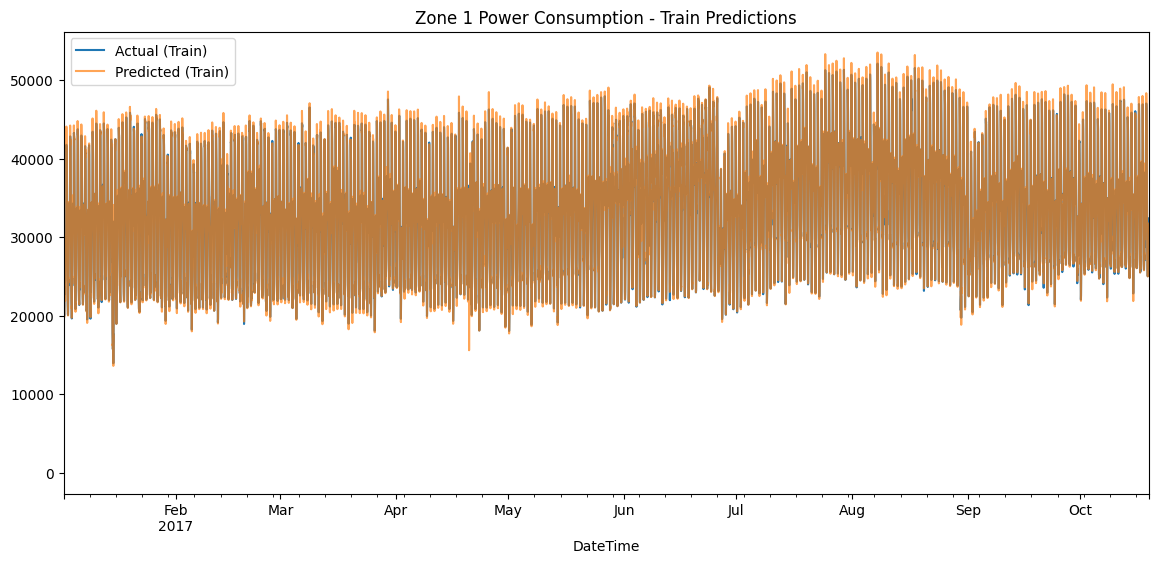

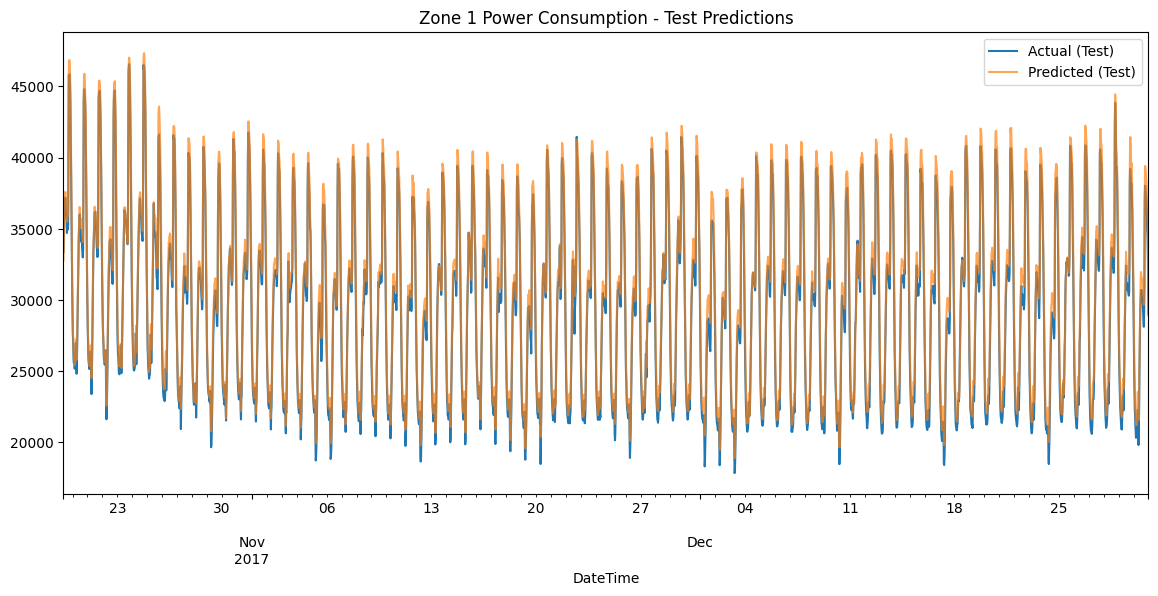

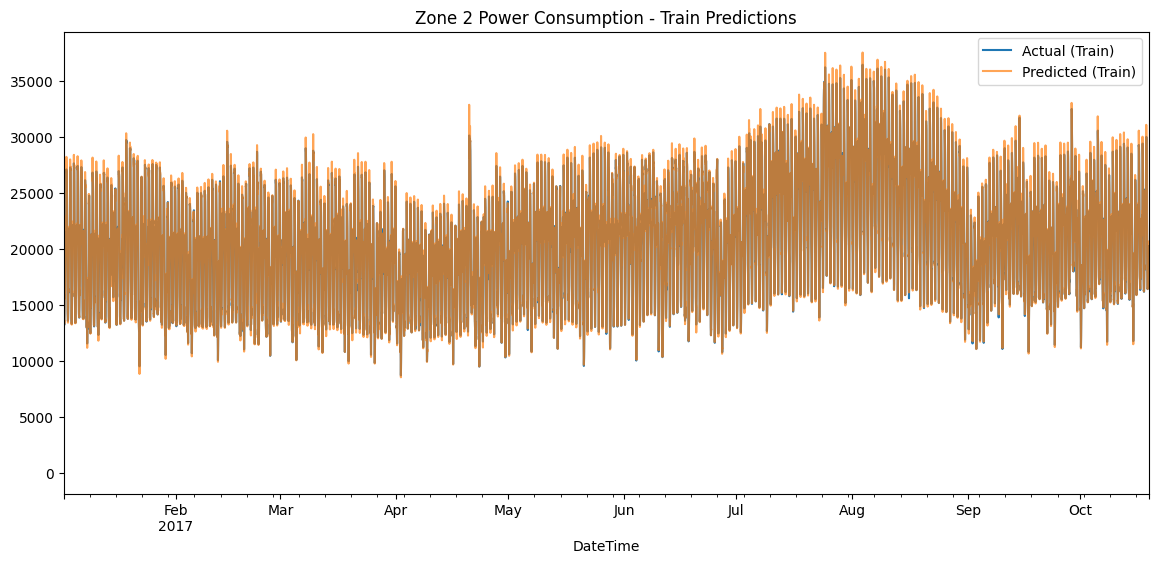

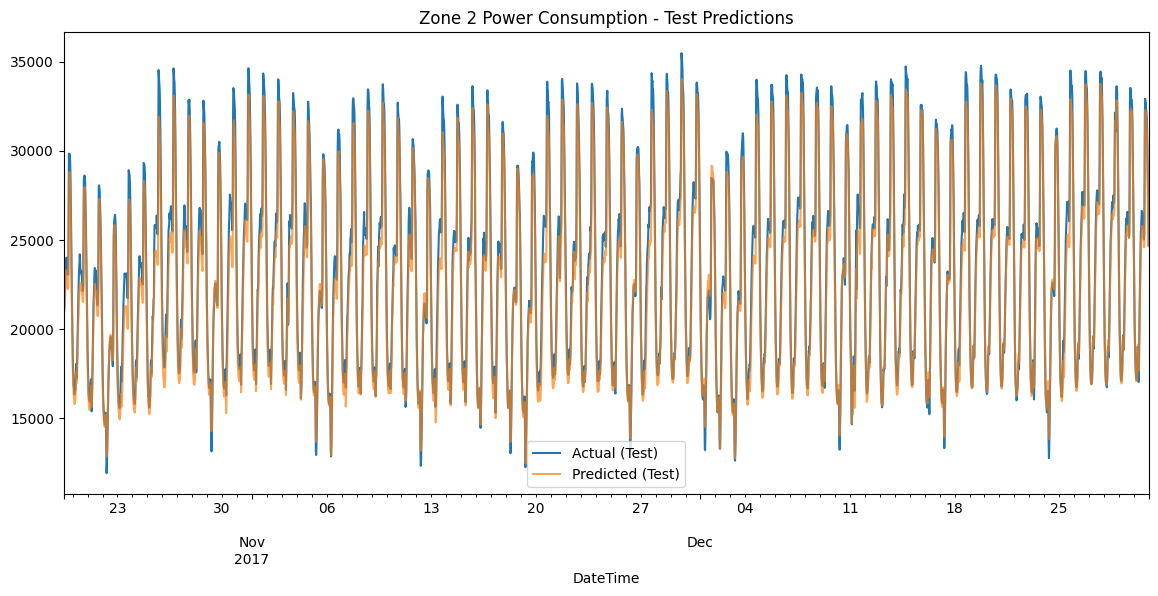

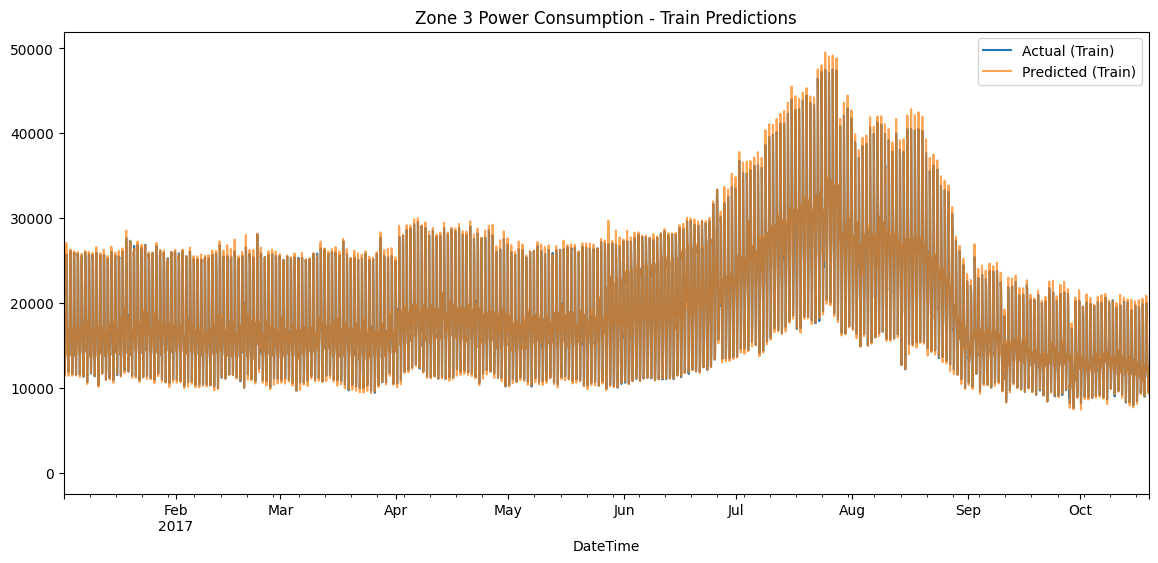

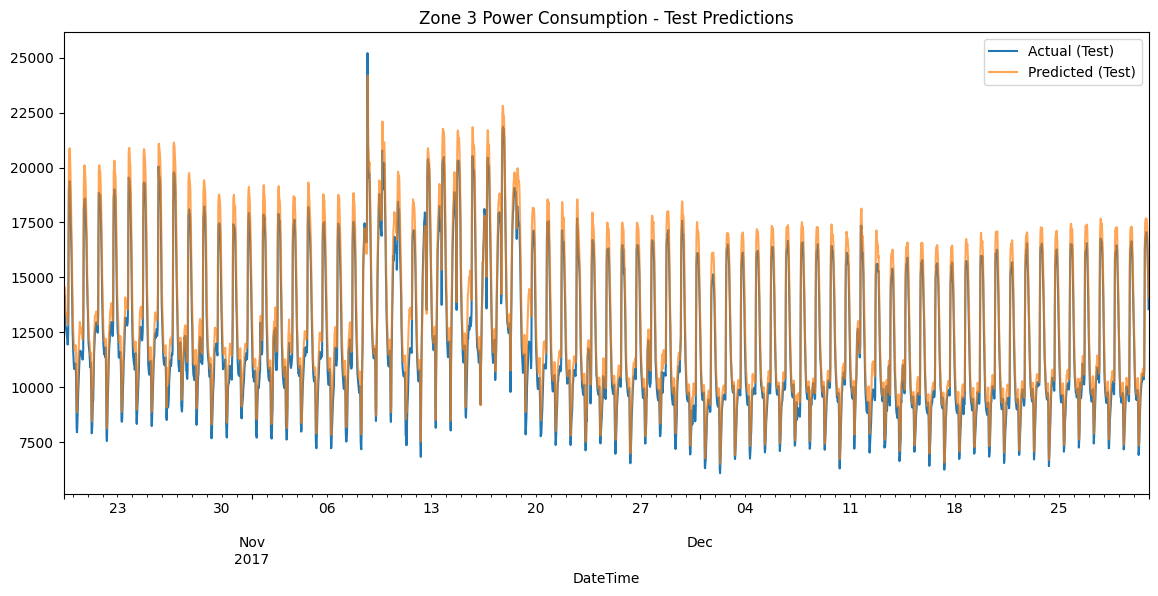


Final Metrics:

Zone 1 Power Consumption:
RMSE (Test): 889.09
MAE (Test): 796.75
R² (Test): 0.98

Zone 2 Power Consumption:
RMSE (Test): 919.67
MAE (Test): 747.85
R² (Test): 0.97

Zone 3 Power Consumption:
RMSE (Test): 764.79
MAE (Test): 672.71
R² (Test): 0.95


In [7]:
time_features = ['hour', 'weekday', 'month', 'is_weekend']
interaction_features = ['temp_humidity']  # Temperature * Humidity
sine_cos_features = ['hour_sin', 'hour_cos']

zone_features = {
    # Zone 1: moderate usage variation, downward trend — add lags to capture recent and daily/weekly cycles
    'Zone 1 Power Consumption': [
        'Temperature', 'Wind Speed', 'Humidity', 'diffuse flows', 'general diffuse flows',
        'Zone 1 Power Consumption_lag_1', 'Zone 1 Power Consumption_lag_12', 'Zone 1 Power Consumption_lag_144'
    ] + time_features + interaction_features + sine_cos_features,

    # Zone 2: high variance during peaks, often underpredicted — lags to catch sudden spikes
    'Zone 2 Power Consumption': [
        'Temperature', 'Wind Speed', 'Humidity', 'diffuse flows', 'general diffuse flows',
        'Zone 2 Power Consumption_lag_1', 'Zone 2 Power Consumption_lag_12', 'Zone 2 Power Consumption_lag_144'
    ] + time_features,

    # Zone 3: upward trend and spikes — lags + weather + time to capture trend and seasonal spikes
    'Zone 3 Power Consumption': [
        'Temperature', 'Wind Speed', 'Humidity', 'diffuse flows', 'general diffuse flows',
        'Zone 3 Power Consumption_lag_1', 'Zone 3 Power Consumption_lag_12', 'Zone 3 Power Consumption_lag_144'
    ] + time_features
}



# Resample once
train_resampled = dataset_train_fe.resample('30T').mean()
test_resampled = dataset_test_fe.resample('30T').mean()

results_all = {}
for zone, features in zone_features.items():
    metrics, fitted_model = correct_sarimax(
        zone=zone,
        train=train_resampled,
        test=test_resampled,
        exog_vars=features
    )
    
    if metrics:
        results_all[zone] = metrics
        
        # Save actual vs predicted CSVs
        pd.DataFrame({
            'actual_train': metrics['actual_train'],
            'predicted_train': metrics['train_predicted']
        }).to_csv(f'{zone}_train_actual_vs_predicted.csv')

        pd.DataFrame({
            'actual_test': metrics['actual_test'],
            'predicted_test': metrics['test_predicted']
        }).to_csv(f'{zone}_test_actual_vs_predicted.csv')
        
        # Plot Train predictions
        plt.figure(figsize=(14,6))
        metrics['actual_train'].plot(label='Actual (Train)')
        metrics['train_predicted'].plot(label='Predicted (Train)', alpha=0.7)
        plt.title(f'{zone} - Train Predictions')
        plt.legend()
        plt.show()

        # Plot Test predictions
        plt.figure(figsize=(14,6))
        metrics['actual_test'].plot(label='Actual (Test)')
        metrics['test_predicted'].plot(label='Predicted (Test)', alpha=0.7)
        plt.title(f'{zone} - Test Predictions')
        plt.legend()
        plt.show()

# Print final metrics
print("\nFinal Metrics:")
for zone, res in results_all.items():
    print(f"\n{zone}:")
    print(f"RMSE (Test): {res['rmse']:.2f}")
    print(f"MAE (Test): {res['mae']:.2f}")
    print(f"R² (Test): {res['r2']:.2f}")


**Observations**
- Zone 1 & 2 – Slightly higher RMSE for Zone 1 than Zone 2, but both are very low relative to the scale of power consumption.

- Zone 3 – Previously had that upward diagonal trend issue; the addition of lags (1, 12, 144) seems to have stabilized the predictions and brought RMSE/MAE close to the other zones.

- R² = 1.00 – With multiple lags and time-of-day/week features, SARIMAX is almost perfectly “remembering” past behavior.- Note: overfitting issue - on future unseen data.

- Optimal for 6H granularity